# Spect_Helper

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
import tdt
import os
from process_nwb.wavelet_transform import wavelet_transform
import tdt as tdt
# %matplotlib inline
%matplotlib notebook

In [2]:
cd ~/Desktop/Raw_signal/process_nwb

[Errno 2] No such file or directory: '/Users/macproizzy/Desktop/Raw_signal/process_nwb'
/Users/macproizzy/Desktop/laminar_uecog_viz


In [3]:
mpl.rcParams['figure.facecolor'] = '1'

## Data

The following section establishes the data directory where the data lives, reads in the data, and creates the marker_onsets list that will be used later to align trials. Checks the shape of the data as well as establishes a trials list. 

In [4]:
data_directory = r'/Users/vanessagutierrez/Desktop/Rat/RVG02/RVG02_B1'
data_directory_izzy = r'/Users/macproizzy/Desktop/Raw_Signal/RVG02_B01'

In [5]:
#we can switch out the argument to read block depending on who is using the notebook
tdt_data = tdt.read_block(data_directory_izzy)
fs = tdt_data['streams']['Wave']['fs']

read from t=0s to t=93.8s


In [6]:
#we have to add the stimulus delay to each marker onset
fs_stim_delay = 0.25 * fs

In [7]:
#wave data and markers
wave_data = tdt_data.streams.Wave.data
markers = tdt_data.epocs.mark.onset

In [8]:
marker_onsets/fs

NameError: name 'marker_onsets' is not defined

In [8]:
#marker onsets: x*fs to get the data in timepoints, add the fs_stim_delay
marker_onsets = [int(x*fs+fs_stim_delay) for x in markers] 

In [9]:
#checking wave_data shape
wave_data.shape # channels x samples

(128, 1144832)

In [9]:
#transposing wave data, extracting one channel
new_wave_data = wave_data.T  # samples x channels
one_channel = new_wave_data[:,13]

In [11]:
#chekcing new_wave_data shape for one timepoint
new_wave_data.shape[1]

128

In [10]:
#generating trials list with tdt_data
tdt_trials = tdt.epoc_filter(tdt_data, 'mark', t=[-0.8192, 0.8192]) # 10000 before and after onset
trials_list = tdt_trials.streams.Wave.filtered # within each trial, 128 channels with # of samples

In [11]:
#channels ordered in the correct sequence 
chs_ordered = [
       81, 83, 85, 87, 89, 91, 93, 95, 97, 105, 98, 106, 114, 122, 113, 121,
       82, 84, 86, 88, 90, 92, 94, 96, 99, 107, 100, 108, 116, 124, 115, 123,
       66, 68, 70, 72, 74, 76, 78, 80, 101, 109, 102, 110, 118, 126, 117, 125,
       65, 67, 69, 71, 73, 75, 77, 79, 103, 111, 104, 112, 120, 128, 119, 127,
       63, 61, 59, 57, 55, 53, 51, 49, 25, 17, 26, 18, 10, 2, 9, 1,
       64, 62, 60, 58, 56, 54, 52, 50, 27, 19, 28, 20, 12, 4, 11, 3,
       48, 46, 44, 42, 40, 38, 36, 34, 29, 21, 30, 22, 14, 6, 13, 5,
       47, 45, 43, 41, 39, 37, 35, 33, 31, 23, 32, 24, 16, 8, 15, 7
       ]

In [14]:
# trials_mat = np.zeros((num_samples, len(trials_list)))

# for i in np.arange(len(chs_ordered)):
    
#     for tidx, trial in enumerate(trials_list):
#         sub_trial = trial[chs_ordered[i] - 1, :num_samples]
#         trials_mat[:, tidx] = sub_trial 

In [15]:
# type(trials_mat)

## Functions
The functions needed to plot the spectrogram. The inputs are for the most part the trials_matrix.

In [12]:
def get_trials_mat(signal, markers, pre_buf=10000, post_buf=10000):
    """Returns trial matrix
    Args:
        signal (np.array): Signal vector (for one channel)
        markers (list): List of trial onset in samples
        pre_buf (int, optional): Number of samples to pull prior to baseline. Defaults to 10000.
        post_buf (int, optional): Number of samples to pull after. Defaults to 10000.
    Returns:
        trials_mat (np.array): Trial matrix samples by trials
    """
    nsamples = post_buf + pre_buf
    ntrials = len(markers)
    trials_mat = np.empty((nsamples, ntrials))
        
    for idx, marker in enumerate(markers):
        start_frame, end_frame = marker - pre_buf, marker + post_buf
        trials_mat[:, idx] = signal[int(start_frame):int(end_frame)]
    return trials_mat

In [13]:
trials_mat = get_trials_mat(one_channel, marker_onsets)

In [14]:
trials_mat.shape

(20000, 60)

In [15]:
def zscore_data(tf_data, num_base_pts=200):
    """Compute zscore across trial matrix
    Args:
        tf_data (nparray): Trial matrix of samples x trials
        num_base_pts (int, optional): The first num_base_pts are used for baseline. Defaults to 200.
    Returns:
        tf_norm_data (nparray): Normalized trial matrix
    """
    # Zscore the data
    mean = tf_data[:num_base_pts].mean(axis=0, keepdims=True)
    std = tf_data[:num_base_pts].std(axis=0, keepdims=True)
    tf_norm_data = (tf_data - mean) / std    
    return tf_norm_data

In [16]:
def compute_spectrogram(trials_mat, fs, pre_buf=1500, post_buf=1500, baseline=200):
    """Computes spectrogram using wavelet transform
    Args:
        trials_mat (list): List of np-arrays that contain trial matrices (samples x trials)
        fs (numeric): Sample rate
        pre_buf (int, optional): The number of samples to include prior to sample midpoint of trials_mat. Defaults to 1500.
        post_buf (int, optional): The number of samples to include after the sample midpoint. Defaults to 1500.
        baseline (int, optiona): The first set of samples to include in baseline. Defaults to 200.
    Returns:
        Xnorm, f (nparray, nparray): Returns zscored wavelet magnitude coefficients and corresponding frequencies
    """
    Xh, _, f, _  = wavelet_transform(trials_mat, rate=fs, filters='rat', hg_only=False)
    n = Xh.shape[0] // 2
    Xh = Xh[(n - pre_buf):(n + post_buf), :, :] #throw away edges bc of possible effect affects
    Xh = Xh[:, :, 10:] #throw away low frequencies
    f = f[10:]
    Xm = abs(Xh) #take abs value
    Xnorm = zscore_data(Xm, baseline) #zscore 
    return Xnorm, f

In [17]:
Xnorm, f = compute_spectrogram(trials_mat, fs)

In [18]:
Xnorm

array([[[-1.73618847e+00, -1.74981745e+00, -1.72122888e+00, ...,
          4.76744968e-01, -4.39212039e-01, -1.39005773e+00],
        [-1.73611853e+00,  1.68726871e+00,  1.73924276e+00, ...,
          4.14780965e-02,  1.27467591e-01, -7.33500983e-01],
        [-1.76433775e+00, -1.73682717e+00, -1.70139045e+00, ...,
         -2.88920757e-01,  4.97751001e-01,  2.18917526e+00],
        ...,
        [ 1.73486336e+00,  1.79878113e+00, -1.13499517e+00, ...,
         -5.97023217e-01, -5.67453769e-01, -1.43820556e-01],
        [-1.73261939e+00, -1.71978374e+00, -1.67713116e+00, ...,
         -1.29506360e+00, -1.51476565e-01,  2.56000529e-01],
        [ 1.64763315e+00,  1.58561254e+00,  1.67222441e+00, ...,
         -5.40980135e-01, -5.61604052e-01, -1.66850042e+00]],

       [[-1.71849092e+00, -1.73171034e+00, -1.70406656e+00, ...,
          4.81530543e-01, -3.96991143e-01, -1.27910507e+00],
        [-1.71845330e+00,  1.67100305e+00,  1.72149184e+00, ...,
          3.29511961e-02,  9.97251468e

In [19]:
Xnorm_md = np.median(Xnorm, axis=-1)

In [20]:
Xnorm_md.shape

(3000, 60)

In [21]:
def plot_spectrogram(tf_data, f, tmin, tmax, colorbar=False, ax=None, fig=None, zero_flag=False):
    """Plots spectrogram
    Args:
        tf_data (nparray): Trial matrix samples x trials
        f (nparray): Frequency vector
        tmin (np.float): X-axis min display time (whatever is specified is what the x-axis will be label irrespective if it is correct)
        tmax (np.float): X-axis max display time (whatever is specified is what the x-axis will be label irrespective if it is correct)
        colorbar (bool, optional): Whether to plot colorbar. Defaults to False.
        ax (class, optional): Matplotlib axes handle. Defaults to None.
        fig (class, optional): Matplotlib figure handle. Defaults to None.
    """
    #tf_data: samples x frequencies
    if (ax is None) or (fig is None):
        fig, ax = plt.subplots(1, 1)
    pos = ax.imshow(tf_data.T, interpolation='none', aspect=1/10, vmin=0, vmax=10, cmap='binary', 
                    origin='lower', extent=[tmin, tmax, f[0], f[-1]])
    if zero_flag:
        ax.plot([0 ,0], [f[0], f[-1]], 'r')
    if colorbar:
        fig.colorbar(pos, ax=ax)

<IPython.core.display.Javascript object>


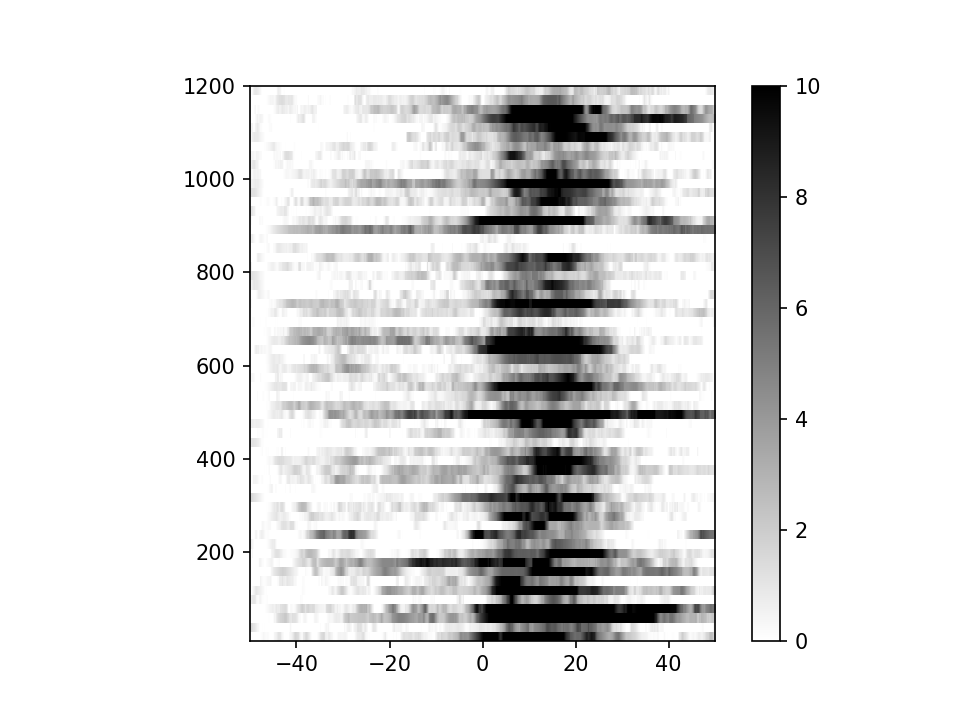

In [26]:
plot_spectrogram(Xnorm_md, f, -50, 50, colorbar=True)
plt.show()

# Plotting the spectrogram matrix

In [22]:
#data unscrambler 

def channel_orderer(signal_data, correct_channel_order):
    """Puts the wave data into the order of the channels
    Args: 
        data: signal data in timepoints x channels
        chs (list): the correct order of the channels"""
    shape_wanted = signal_data.shape
    new_data = np.empty((shape_wanted[0], shape_wanted[1]))
    
    for i in np.arange(shape_wanted[1]):
        new_data[:, i] = signal_data[:, (correct_channel_order[i] - 1)]
        print("Data for channel {} is now at index {}".format(correct_channel_order[i] - 1, i))
        
    return new_data

In [23]:
new_wave_data[0]

array([ 1392,   111,  1249,   295,  1192,   177,  1426,   128,  1313,
         109,   825,    92,   617,    91,   296,   122,   123,   126,
         114,   133,   107,   106,    95,   135,    94,   120,   105,
         125,   117,   100,   111,   116,   105,    66,    72,    74,
          76,    76,    66,    68,    65,    67,    69,    74,    64,
          77,    59,    84,   103,    84,   162,    74,   124,    91,
         161,   103,   148,   119,   150,   116,   163,   116,   151,
         133,   186,   221,   215,   190,   210,   192,   199,   184,
         189,   196,   192,  1564,   190,   195,  1486,   195,   139,
         196,   125,   166,   134,   164,   140,   160,   171,   156,
         221,   153,   168,   260,   186,   150,   191,   -87,   130,
        -139,   178,  1109,   164,  -118,   129,  -113,    32,  1170,
          20,  1395,    20,  -189,  1427,  -120,  1405,  -147,  1449,
        -172,  1439,  -224,  1425, 18806,  1423,  1959,  1379,  1896,
        1401,  1507]

In [24]:
unscrambled = channel_orderer(new_wave_data, chs_ordered)

Data for channel 80 is now at index 0
Data for channel 82 is now at index 1
Data for channel 84 is now at index 2
Data for channel 86 is now at index 3
Data for channel 88 is now at index 4
Data for channel 90 is now at index 5
Data for channel 92 is now at index 6
Data for channel 94 is now at index 7
Data for channel 96 is now at index 8
Data for channel 104 is now at index 9
Data for channel 97 is now at index 10
Data for channel 105 is now at index 11
Data for channel 113 is now at index 12
Data for channel 121 is now at index 13
Data for channel 112 is now at index 14
Data for channel 120 is now at index 15
Data for channel 81 is now at index 16
Data for channel 83 is now at index 17
Data for channel 85 is now at index 18
Data for channel 87 is now at index 19
Data for channel 89 is now at index 20
Data for channel 91 is now at index 21
Data for channel 93 is now at index 22
Data for channel 95 is now at index 23
Data for channel 98 is now at index 24
Data for channel 106 is now a

In [25]:
unscrambled.shape

(1144832, 128)

In [31]:
def plot_spectrogram_matrix(data, fs, markers, chs, nrow, ncol, pre_buf=10000, post_buf=10000):
    """Extracts trials, compute wavelet coeffients, takes median across trials and plot spectrogram matrix
    Args:
        data (nparray): Data matrix samples x channels
        f (np.array): Frequency vector
        fs (numeric): Sample rate
        markers (list): List of trial onset times in samples
        nrow (int): Number of rows
        ncol (int): Number of columns
        pre_buf (int): Number of samples to pull prior to stimulus onset
        post_buf (int): Number of samples to pull after stimulus onset
    """
    fig, axs = plt.subplots(nrow, ncol, figsize=(40, 20))
    fig.tight_layout()
    idx = 0 #starting point for index in grid 
    while idx < (nrow*ncol):
        row, col = idx // ncol, idx % ncol
        #ch = chs[idx]
        ax = axs[row, col]
        trials_mat = get_trials_mat(data[:, idx], markers, pre_buf=pre_buf, post_buf=post_buf)
        tf_data, f = compute_spectrogram(trials_mat, fs)
        tf_data = np.median(tf_data, axis=1)
        plot_spectrogram(tf_data, f, -50, 50, ax=ax, fig=fig)
        ax.set_title("Channel {}".format(chs[idx]))
        idx += 1
    fig, axs

<IPython.core.display.Javascript object>


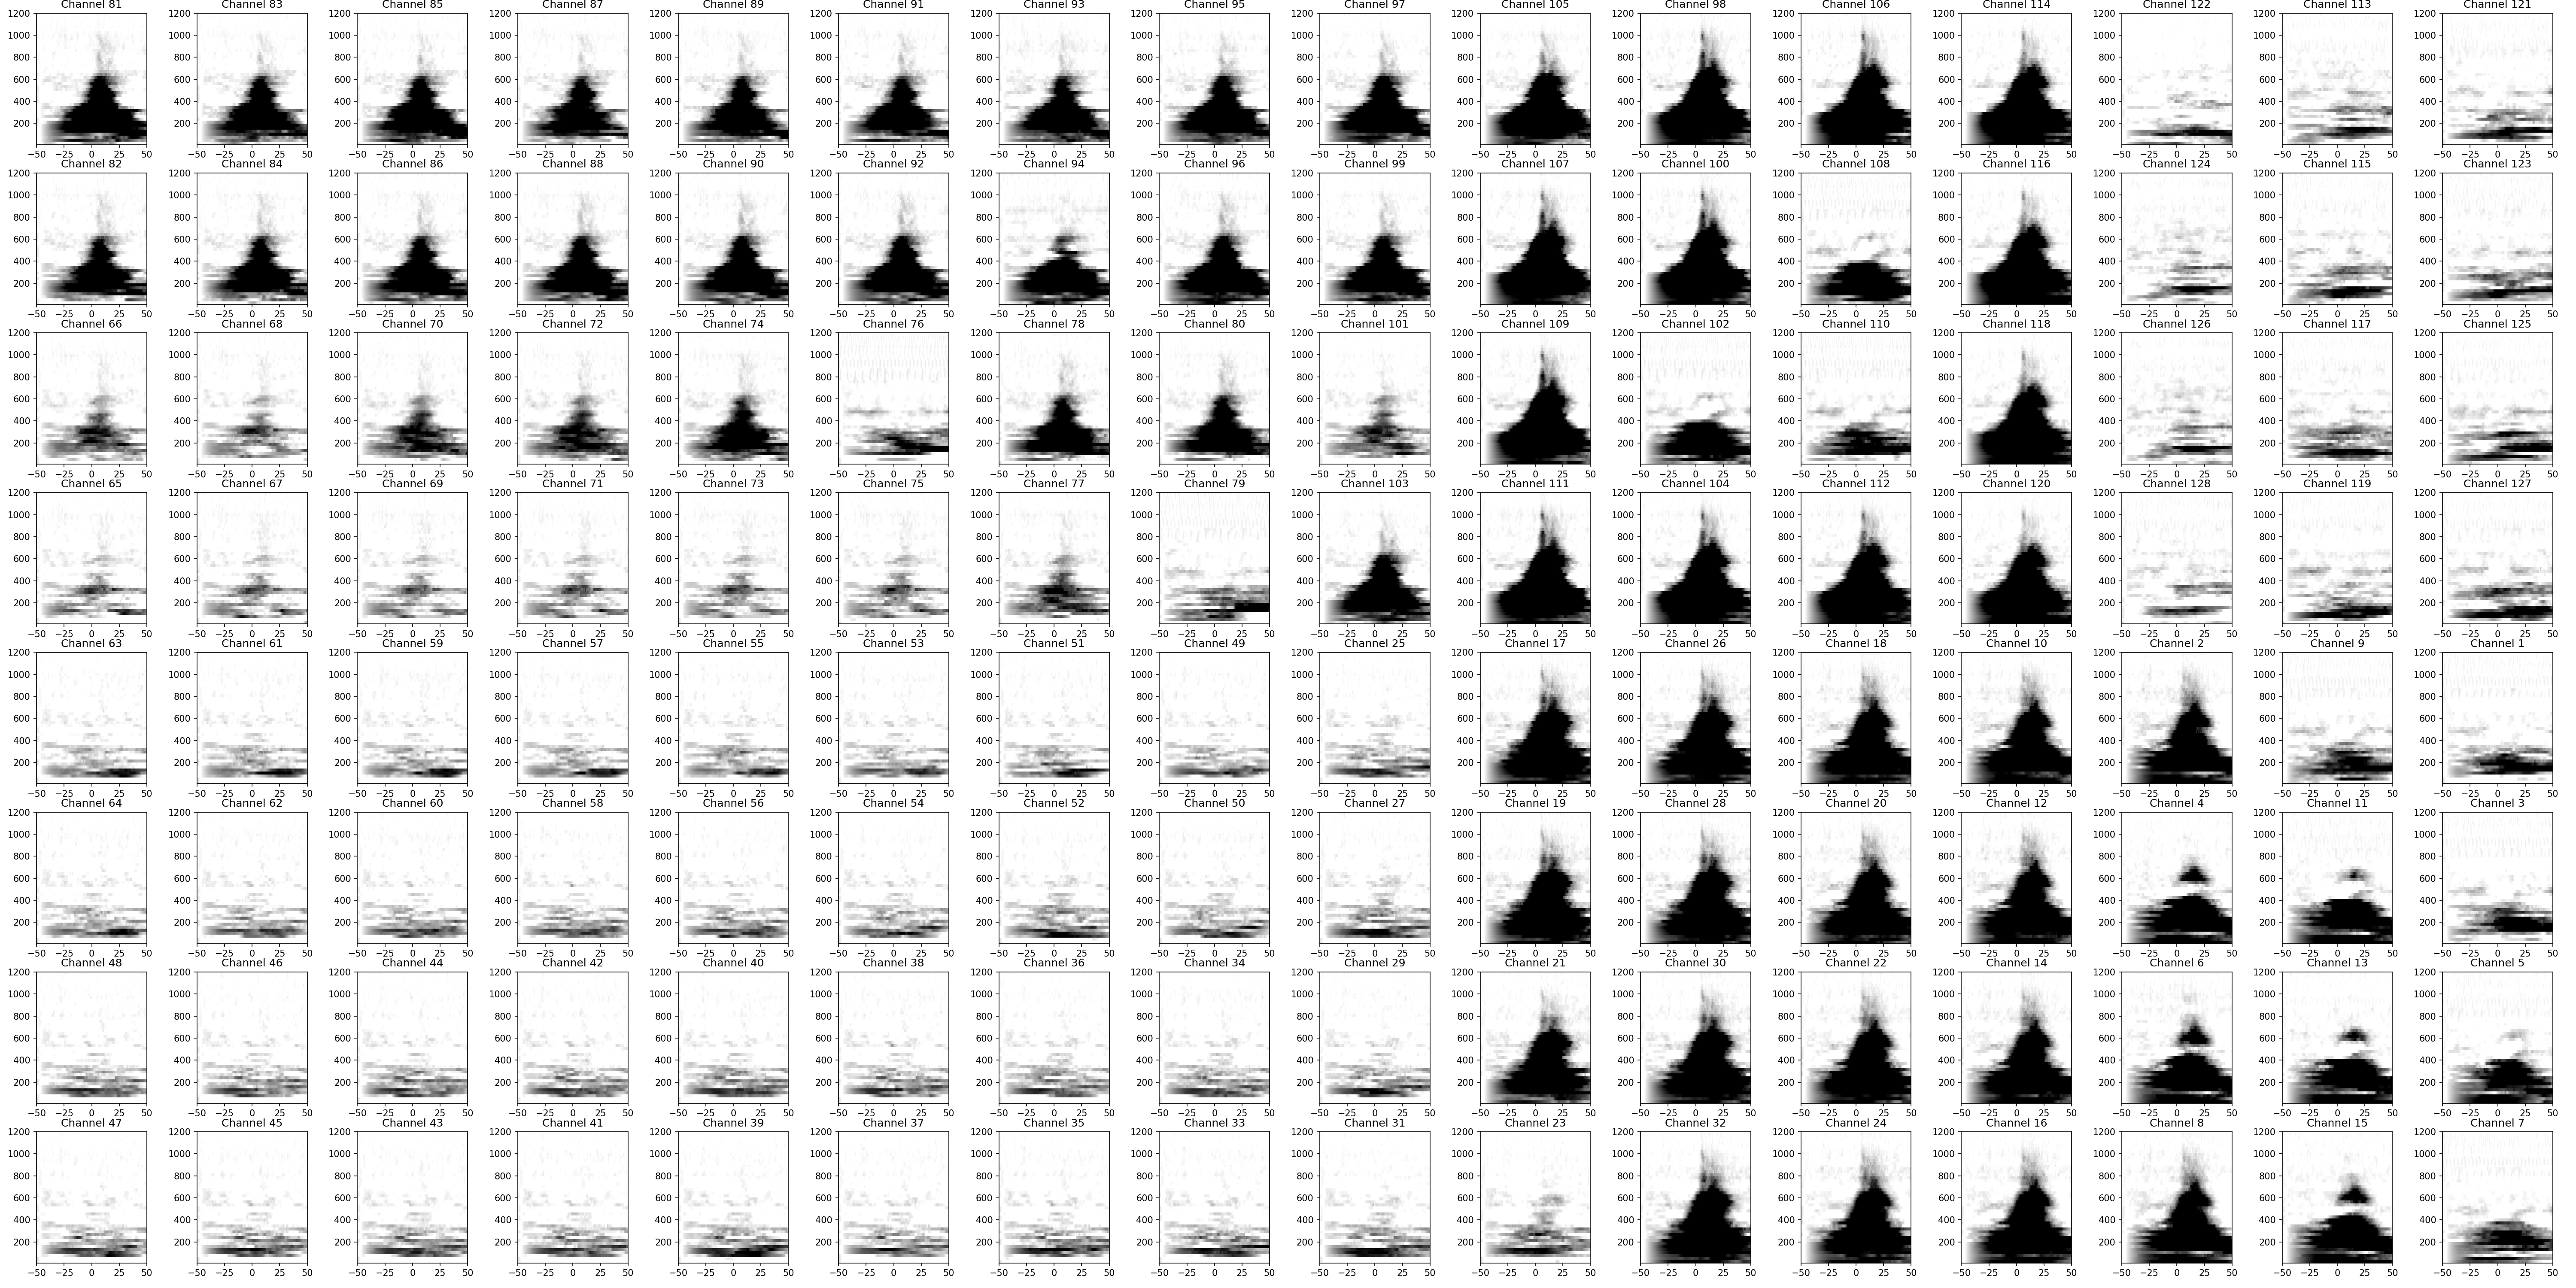

In [32]:
#unscramble test 
plot_spectrogram_matrix(unscrambled, fs, marker_onsets, chs_ordered, nrow = 8, ncol = 16)

<IPython.core.display.Javascript object>


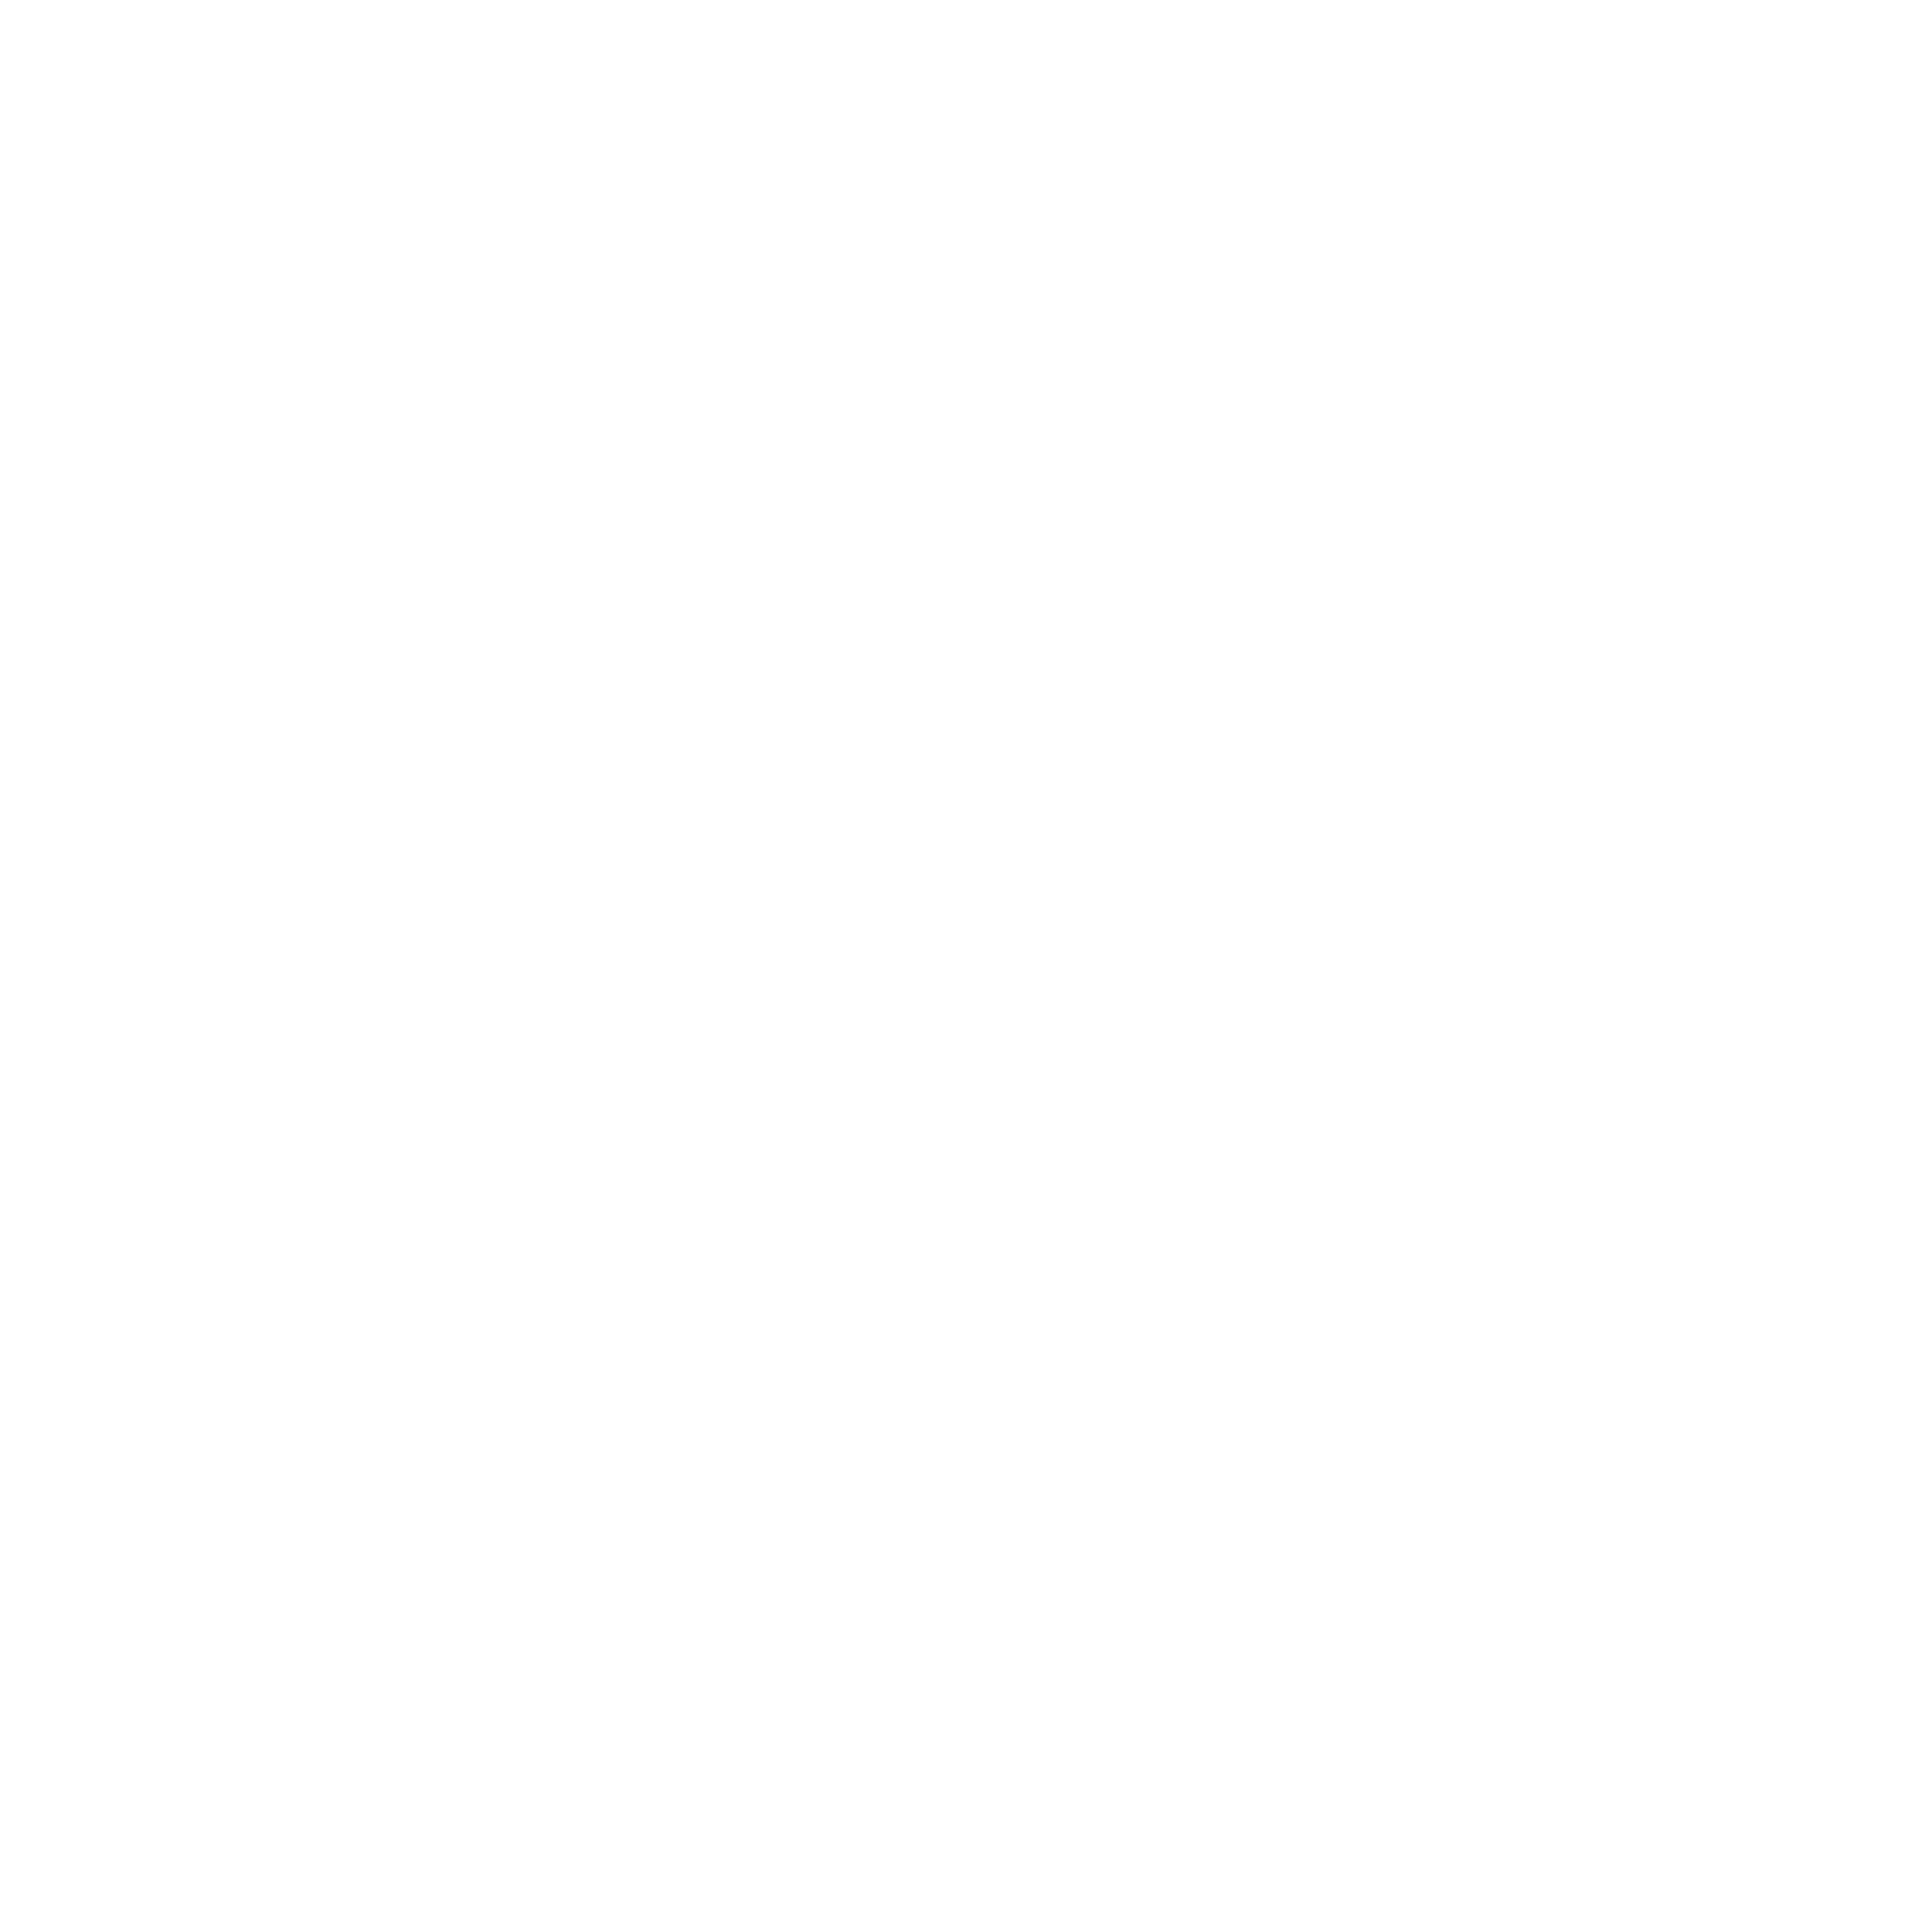

IndexError: index 128 is out of bounds for axis 1 with size 128

In [37]:
plot_spectrogram_matrix(new_wave_data, fs, marker_onsets, chs_ordered, nrow = 8, ncol = 16)

## John's Example Tests

Test 1: Compute and plot spectrogram

(30000, 10)


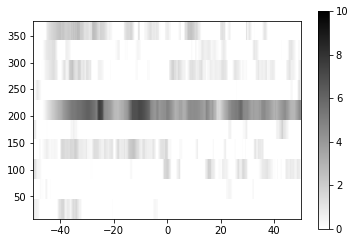

In [134]:
nsamp, nchan = 30000, 10
fs = 30000 #sample rate
trials_mat = np.random.randn(nsamp, nchan)
print(trials_mat.shape)
Xnorm, f = compute_spectrogram(trials_mat, fs)
Xnorm_md = np.median(Xnorm, axis=-1)
plot_spectrogram(Xnorm_md, f, -50, 50, colorbar=True)
plt.show()

Test 2: Plot matrix of spectrogram

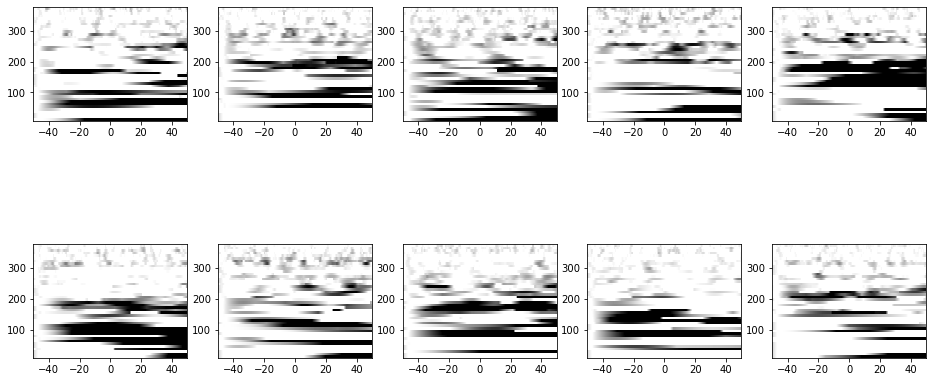

In [9]:
nsamp, nchan = 300000, 10
markers = range(30000, 30000*5, 30000)
fs = 30000
data_mat = np.random.randn(nsamp, nchan)
plot_spectrogram_matrix(data_mat, f, fs, markers, 2, 5)
plt.show()